# Trademark ducky dataset

> Georgios Varnavides | Oct 23 2025  
>
> Sample: graphene substrate ducky  
> Sampling conditions: 4 Ang step-sizes  
> Imaging conditions: 20 mrad, 500 A  

In [1]:
import abtem
import ase
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import dask 

abtem.config.set({"device": "gpu"})

dask.config.set({"num_workers": 1})

In [2]:
with h5py.File("../data/ducky_coords.mat","r") as f:
    atoms = f['atoms'][:].T
    cell_dim = f['cell_dim'][:].ravel()

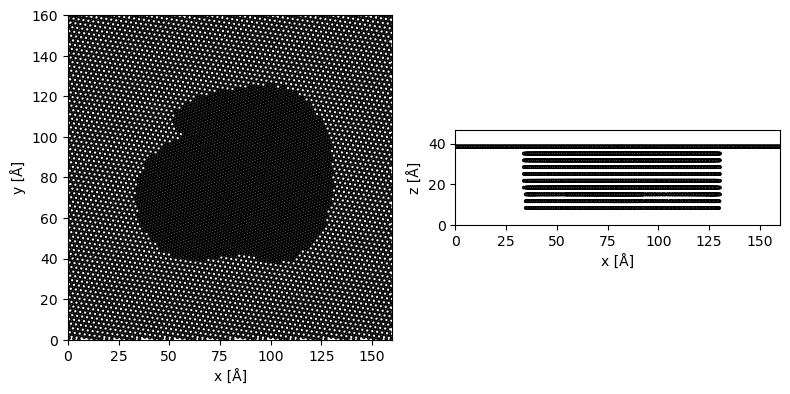

In [3]:
with h5py.File("../data/ducky_coords.mat","r") as f:
    atoms = f['atoms'][:].T
    cell_dim = f['cell_dim'][:].ravel()

ducky_atoms = ase.Atoms(
    numbers=atoms[:,-1],
    positions=atoms[:,:3],
    cell=np.array([160,160,atoms[:,2].max() + atoms[:,2].min()])
)

del ducky_atoms[(ducky_atoms.positions[:,0]<20) | (ducky_atoms.positions[:,0]>180)]
del ducky_atoms[(ducky_atoms.positions[:,1]<20) | (ducky_atoms.positions[:,1]>180)]
ducky_atoms.translate([-20,-20,0])

fig, axs = plt.subplots(1,2,figsize=(8,4))

abtem.show_atoms(ducky_atoms,ax=axs[0],tight_limits=True)
abtem.show_atoms(ducky_atoms,plane='xz',ax=axs[1],tight_limits=True)

fig.tight_layout()

[########################################] | 100% Completed | 625.14 ms
[########################################] | 100% Completed | 101.37 ms


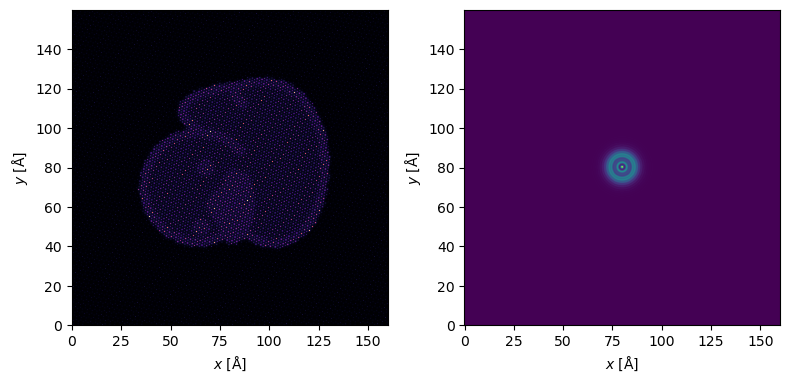

In [4]:
potential = abtem.Potential(
    ducky_atoms,
    gpts=(1600,1600),
    slice_thickness=0.83875,
    device='gpu',
).build()

probe = abtem.Probe(
    energy=80e3,
    semiangle_cutoff=20,
    defocus=500,
).match_grid(
    potential
)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    
potential.project().show(
    ax=ax1,
    cmap='magma',
)

probe.show(ax =ax2);

fig.tight_layout()

In [5]:
pixelated_detector = abtem.PixelatedDetector(
    max_angle=None,
)

# grid_scan = abtem.GridScan(
#     (0, 0), (160,160),
#     sampling=5,
#     endpoint=True,
# )

grid_scan = abtem.GridScan(
    (8, 8), (152,152),
    sampling=4,
    endpoint=True,
)


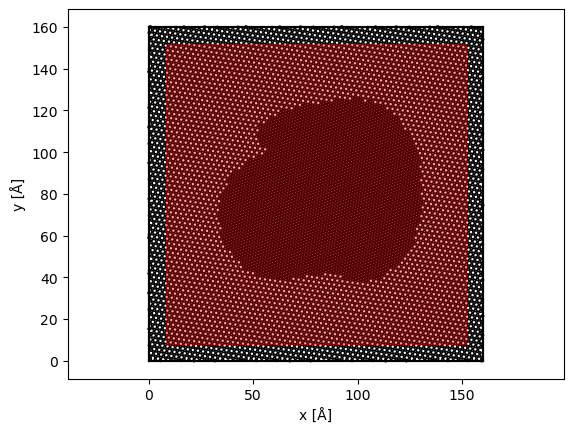

In [6]:
fig, ax = abtem.show_atoms(ducky_atoms)
grid_scan.add_to_plot(ax)

In [7]:
measurement = probe.scan(
    potential=potential,
    scan=grid_scan,
    detectors=pixelated_detector,
).compute(
)

[########################################] | 100% Completed | 51.34 s


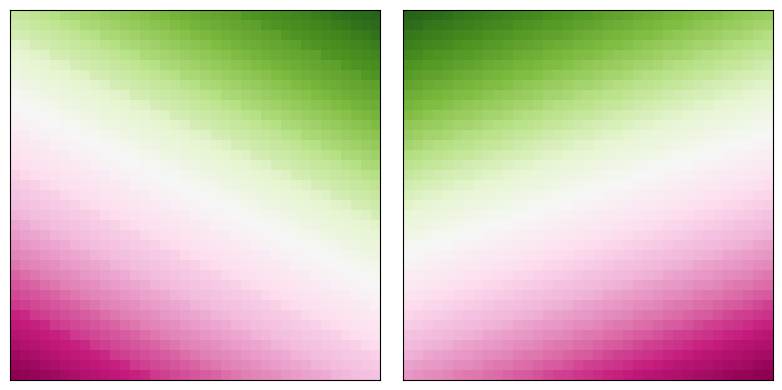

In [8]:
# plane-wave descan
sx, sy = grid_scan.shape
bin_factor = 4

x = np.linspace(-80,80,sx)
y = np.linspace(-80,80,sy)

descan_x = np.round((y[None,:]-2*x[:,None]) / grid_scan.sampling[0])
descan_y = np.round((-y[None,:]-3*x[:,None]) / grid_scan.sampling[1])

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(descan_x/bin_factor,cmap='PiYG')
axs[1].imshow(descan_y/bin_factor,cmap='PiYG')
for ax in axs:
    ax.set(xticks=[],yticks=[])
fig.tight_layout()

In [9]:
crop_x, crop_y = (np.array(potential.gpts) - 200 * bin_factor) // 2
array = np.zeros((sx,sy,200,200),dtype=measurement.array.dtype)
for i in range(sx):
    print(f"{i+1}/{sx}", end="\r")
    for j in range(sy):
        dp = measurement.array[i,j]
        # dp = rotate(dp,15,reshape=False,order=1) # rotate
        # dp = np.roll(dp,(int(descan_x[i,j]),int(descan_y[i,j])),axis=(0,1)) # descan
        dp = dp[crop_x:-crop_x,crop_y:-crop_y].reshape((200,bin_factor,200,bin_factor)).sum((1,3)) # bin
        array[ i,j] = dp

array_sums = array.sum((-2,-1))
print(f"Smallest array sum (should be close to 1): {array_sums.min()}")

Smallest array sum (should be close to 1): 0.9994474053382874


## Save Multidimensional Dataset
Temporary fix, until abTEM supports zarr>3.

In [10]:
print(bin_factor)
print()
print(measurement.angular_sampling)
print(measurement.angular_sampling[0]*bin_factor)

print()
print(measurement.sampling)
print(measurement.sampling[0]*bin_factor)

print()
print(grid_scan.sampling)

4

(0.2609822535305853, 0.2609822535305853)
1.0439290141223412

(0.00625, 0.00625)
0.025

(4.0, 4.0)


In [17]:
print(bin_factor)
print()
print(measurement.angular_sampling)
print(measurement.angular_sampling[0]*bin_factor)

print()
print(measurement.sampling)
print(measurement.sampling[0]*bin_factor)

print()
print(grid_scan.sampling)

4

(0.2609822535305853, 0.2609822535305853)
1.0439290141223412

(0.00625, 0.00625)
0.025

(4.9655172413793105, 4.9655172413793105)


In [10]:
print(bin_factor)
print()
print(measurement.angular_sampling)
print(measurement.angular_sampling[0]*bin_factor)

print()
print(measurement.sampling)
print(measurement.sampling[0]*bin_factor)

print()
print(grid_scan.sampling)

4

(0.2609822535305853, 0.2609822535305853)
1.0439290141223412

(0.00625, 0.00625)
0.025

(4.0, 4.0)


In [11]:
np.save("./temp_ducky_4A_clean.npy",array)
# np.save("./temp_ducky_4A.npy",array)
# np.save("./temp_ducky_5A.npy",array)
# np.save("./temp_ducky_5A_clean.npy",array)


In [12]:
from pathlib import Path
print(Path("./").resolve())

/home/amccray/code/quantem-tutorials/simulation_notebooks


In [17]:
import quantem as em
import numpy as np
from quantem.core.visualization import show_2d

step_size = 4
clean = True 

array = np.load("./temp_ducky_4A_clean.npy")
# array = np.load("./temp_ducky_4A.npy")
# array = np.load("./temp_ducky_4A.npy")
# array = np.load("./temp_ducky_5A.npy")
# array = np.load("./temp_ducky_5A_clean.npy")



In [30]:
dose = 5e4 # e/A^2
dose_per_dp = dose * step_size**2
dose_per_dp

800000.0

In [31]:
noisy_array = np.zeros_like(array)
for i in range(array.shape[0]):
    for j in range(array.shape[1]):
        dp = array[i,j].copy()
        dp = dp / dp.sum() * dose_per_dp
        noisy_array[i,j] = np.random.poisson(dp)


(<Figure size 400x400 with 2 Axes>, <Axes: >)

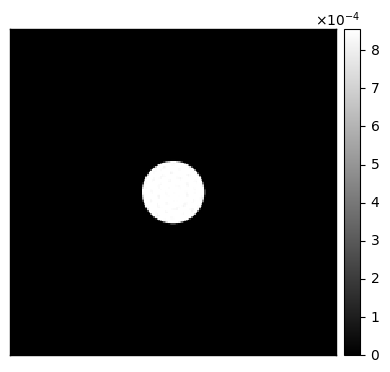

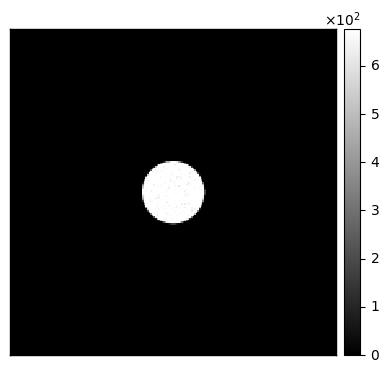

In [32]:
show_2d(array[0,0], cbar=True)
show_2d(noisy_array[0,0], cbar=True)

In [33]:
import quantem as em

# sampling = [
#     grid_scan.sampling[0],
#     grid_scan.sampling[1],
#     measurement.angular_sampling[0]*bin_factor,
#     measurement.angular_sampling[1]*bin_factor,
# ]

sampling = [
    step_size,
    step_size,
    # 1.0439290141223412,
    # 1.0439290141223412,
    0.025,
    0.025,
]

units = ["A","A","A^-1","A^-1"]
# units = ["A","A","mrad","mrad"]

dataset = em.core.datastructures.Dataset4dstem.from_array(
    # array,
    noisy_array,
    sampling=sampling,
    units=units,
)

if clean:
    fname = f"ducky_251105_20mrad_500A-df_{step_size}A-step_{dose:.0e}-dose_clean.zip"
else:
    fname = f"ducky_251105_20mrad_500A-df_{step_size}A-step_{dose:.0e}-dose.zip"
print(fname)
dataset.save(f"/data/shared/resources/example_data/{fname}",mode='o')
dataset.save(f"../data/{fname}",mode='o')

ducky_251105_20mrad_500A-df_4A-step_5e+04-dose_clean.zip
